In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [2]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**One-hot encoding**

In [3]:
 def one_hot_encode(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['gender'], prefix='gender')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

    df = df.drop(columns=['workclass', 'gender', 'fnlwgt', 'education', 'occupation', \
                      'relationship', 'marital', 'race', 'country', 'capgain', \
                      'caploss'])
    return df

# one-hot encoding (for regression mdoels)
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender_Female'=1
# privileged: 'gender_Male'=1

**Parametric Model**

In [5]:
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

size=500
X_train = X_train[0:size]
y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute statistical parity difference**

In [6]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender_Female']==1].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender_Male']==1].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**Compute Accuracy** 

In [9]:
def computeAccuracy(y_true, y_pred):
    accuracy = 0
    for i in range(len(y_true)):
        idx = y_true[i]
        accuracy += y_pred[i][idx]
    accuracy /= len(y_true)
    return accuracy

**First-order derivative of loss function at z with respect to model parameters**

(Pre-computed for all training points)

In [10]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

(Pre-computed for all training points)

In [11]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i + 1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [12]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [13]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numProtected = X_test_orig['gender_Female'].sum()
    numPrivileged = X_test_orig['gender_Male'].sum()
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['gender_Male'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['gender_Female'] == 1:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [14]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    if (size > n):
        size = n
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [15]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Metrics: Initial state**

In [16]:
threshold = 0.0001
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)
    
spd_0 = computeFairness(y_pred_test, X_test_orig)
print("Initial fairness: ", spd_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial fairness:  -0.17171987868277863
Initial loss:  0.40860436582736925
Initial accuracy:  0.7721868753956858


**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [17]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

*H^{-1} computation*

In [18]:
hexact = 1
v1 = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
# ix = 203
# v1 = del_L_del_theta_i(num_params, y_test[ix], X_test[ix], y_pred_test[ix])
if hexact == 1: 
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)
else: #using Hessian vector product
    size_hvp = int(len(X_train) * .01)
    hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v1, hessian_all_points)

**Ground truth influence of each training data point**

In [19]:
# Ground truth influence
# spdgt = ground_truth_influence(X_train, y_train, X_test, X_test_orig)
# with open('delta_spd_ground_truth_v0.txt', 'w') as filehandle:
#     for listitem in delta_spd:
#         filehandle.write('%s\n' % listitem)
gt_spd = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
gt_spd = gt_spd.values.tolist()
spdgt=[]
for i in range(len(gt_spd)):
    spdgt.append(gt_spd[i][0])

**First-order influence of each training data point**

In [19]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Verification of first-order influence (implementation) on log-loss of a single point**

In [21]:
# Misclassified points
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
for i in range(len(X_test)):
    if (y_pred[i][y_test[i]] < y_pred[i][1 - y_test[i]]):
        print(i)

3
9
19
20
47
69
72
78
88
95
107
116
123
127
134
141
146
160
165
166
175
182
184
188
190
192
198
203
206
207
210
212
213
214
228
239
244
247
248
257
272
274
276
288
290
295
299
302
304
310
312
317
318
319
324
325
335
338
347
350
352
354
360
366
367
371
378
381
385
390
396
398
400
408
429
433
443
455
460
468
475
478
481
483
484
486
491
492
494
495
499
503
506
509
510
512
515
526
531
535
536
538
540
547
553
554
559
562
600
602
607
614
634
644
645
651
656
658
662
676
677
687
691
694
698
701
702
713
724
725
736
739
740
744
746
747
750
764
766
768
769
782
783
791
801
803
807
809
817
818
820
822
823
827
830
838
841
846
849
851
853
861
863
870
872
878
881
883
886
887
903
905
906
907
910
911
913
917
918
920
921
927
941
951
952
956
960
971
982
983
984
1005
1006
1012
1017
1018
1021
1026
1027
1029
1031
1034
1035
1036
1040
1045
1054
1063
1069
1088
1089
1091
1094
1105
1111
1116
1119
1123
1126
1127
1138
1141
1142
1143
1145
1149
1154
1162
1164
1167
1171
1178
1182
1206
1213
1218
1219
1227
1230
1234
123

13066
13069
13075
13078
13084
13085
13089
13095
13096
13099
13101
13104
13106
13122
13131
13135
13136
13148
13153
13157
13176
13190
13196
13199
13209
13229
13230
13238
13245
13246
13254
13255
13257
13259
13262
13273
13287
13304
13309
13311
13315
13320
13321
13324
13339
13343
13347
13349
13357
13358
13366
13374
13376
13382
13391
13397
13402
13405
13406
13407
13409
13422
13427
13431
13438
13441
13444
13456
13457
13458
13465
13479
13486
13491
13496
13501
13506
13510
13519
13526
13547
13554
13559
13562
13568
13572
13577
13588
13589
13593
13594
13602
13606
13621
13622
13630
13633
13634
13635
13645
13646
13652
13656
13661
13667
13682
13688
13689
13691
13693
13694
13700
13716
13728
13740
13746
13751
13765
13774
13790
13806
13809
13826
13836
13844
13855
13857
13862
13874
13884
13885
13892
13893
13894
13899
13905
13911
13912
13913
13921
13922
13928
13930
13933
13939
13940
13944
13952
13956
13960
13962
13965
13972
13973
13978
13995
13996
14002
14010
14012
14013
14016
14017
14022
14025
14031
1403

In [31]:
def ground_truth_influence_loss(X_train, y_train, X_test, y_test, idx):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba([X_test[idx]])[0]
    loss_0 = - y_test[idx] * math.log(y_pred[1]) - (1 - y_test[idx]) * math.log(y_pred[0])

    delta_loss = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba([X_test[idx]])[0]
        loss_i = - y_test[idx] * math.log(y_pred[1]) - (1 - y_test[idx]) * math.log(y_pred[0])
        delta_loss_i = loss_i - loss_0
        delta_loss.append(delta_loss_i)
    
    return delta_loss

# ix = 203 #misprediction
# v1 = del_L_del_theta_i(num_params, y_test[ix], X_test[ix], y_pred_test[ix])
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))
# delta_loss_gt = ground_truth_influence_loss(X_train, y_train, X_test, y_test, ix)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


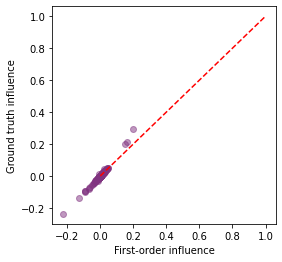

In [23]:
colors = (0.5,0.2,0.5)
# fig = plt.figure()
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(infs_1, delta_loss_gt, c=colors, alpha=0.5)
plt.xlabel('First-order influence')
plt.ylabel('Ground truth influence')
ax.plot((0,1), 'r--')
# ax.plot([0,1],[0,1], transform=ax.transAxes)
plt.show()

**Correlation between first-order and ground truth influences**

In [25]:
print("Spearman rank correlation between 1st order inf and ground truth inf: ", 
      stats.spearmanr(spdgt, infs_1)[0])
print("Pearson correlation coefficient between 1st order inf and ground truth inf: ", 
      stats.pearsonr(spdgt, infs_1)[0])

colors = (0.5,0.2,0.5)
fig = plt.figure()
plt.scatter(infs_1, spdgt, c=colors, alpha=0.5)
plt.xlabel('First-order influence')
plt.ylabel('Ground truth influence')
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 30162 and the array at index 1 has size 500

**Space Partitioner for reducing bias**

In [216]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

def preprocess(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = df.drop(columns=['fnlwgt', 'education.num', 'country', 'capgain', 'caploss'])
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train_ = df_train.drop(columns='income')
y_train_ = df_train['income']

X_test_ = df_test.drop(columns='income')
y_test_ = df_test['income']

size=100
X_train = X_train[0:size]
y_train = y_train[0:size]

In [199]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender']=='Female'].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender']=='Male'].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

def getInfluenceOfSet(indices, f, X_train, y_train, X_test, X_test_, method): 
    del_f = 0
    if (method == 1):
        X = X_train.drop(index=indices, inplace=False)
        y = y_train.drop(index=indices, inplace=False)
        if len(y.unique()) < 2:
            return 0
        clf.fit(X, y)
        y_pred = clf.predict_proba(X_test)
        del_f = computeFairness(y_pred, X_test_)
    elif (method == 2):
        for i in range(len(indices)):
            del_f += infs_1[indices[i]]
    elif (method == 3):
        del_f = second_order_influence(X_train, v1, indices, size_hvp, del_L_del_theta, hessian_all_points)
#     del_f = del_f * 100/f
    return  del_f

def getSplitVal(infs):
    return (np.argmax(np.asarray(infs)))

def getSplitAttribute(cols, cols_continuous, X_train, y_train, X_test, X_train_, X_test_, method):
    splitCol, numRows, score = None, len(X_train_), np.Inf
    infs = []
    vals = []
    idxs = []
    for i in range(len(cols)):
        col = cols[i]
        infs_i = []
        vals_i = []
        idxs_i = []
        if col not in cols_continuous:
            colVals = X_train_[col].unique()
            for val in colVals:
                idx = X_train_[X_train_[col] == val].index
                idxs_i.append(len(X_train)-len(idx))
                infs_i.append(getInfluenceOfSet(idx, spd_0, X_train, y_train, X_test, X_test_, method))
                vals_i.append(val)
                ix = getSplitVal(infs_i)
                if (abs(infs_i[ix]) < abs(spd_0)) and (abs(infs_i[ix]) < score):
                    print("Column passed: ", col)
                    print("Val: ", val)
                    splitCol = col
                    splitIdx = i
                    score = abs(infs_i[ix])
        infs.append(infs_i)
        vals.append(vals_i)
        idxs.append(idxs_i)
    return {'splitCol':splitCol, 'numRows':numRows, 
            'infs': infs[splitIdx], 'vals': vals[splitIdx], 'idxs': idxs[splitIdx]}

def partition(node, maxDepth, minSize, depth, cols, cols_continuous, 
              X_train_, y_train_, X_train, X_test_, X_test, method):
    print("Depth: ", depth)
    if depth >= maxDepth or node['numRows'] < minSize:
        node['children'] = None
        return
    col = node['splitCol']
    if col not in cols_continuous:
        vals = X_train_[col].unique()
        child = [None] * len(vals)
        for i in range(len(vals)):
            idx = X_train_[X_train_[col] == vals[i]].index 
            X = X_train.drop(index=idx, inplace=False)
            y = y_train.drop(index=idx, inplace=False)
            X_ = X_train_.drop(index=idx, inplace=False)
            if len(X) < minSize:
                node['children'] = None
            else:
                cols_ = copy.deepcopy(cols)
                cols_.remove(col)
                child[i] = getSplitAttribute(cols_, cols_continuous,
                                             X, y, X_test, X_, X_test_, method)
                child[i]['col'] = col
                child[i]['val'] = vals[i]
                partition(child[i], maxDepth, minSize, depth + 1, cols_, cols_continuous, 
                  X_, y, X, X_test_, X_test, method)
    node['children'] = child

def buildTree(X_train_, X_train, maxDepth, minSize, method):
    cols = copy.deepcopy(X_train_.columns).tolist()
    cols_continuous = ['age', 'hours']
    X_train = pd.DataFrame(data=X_train, columns=X_train_orig.columns)
    cols = list(set(cols) - set(cols_continuous))
    root = getSplitAttribute(cols, cols_continuous,
                             X_train, y_train, X_test, X_train_, X_test_, method)
    print(root)
    partition(root, maxDepth, minSize, 1, cols, cols_continuous,
              X_train_, y_train_, X_train, X_test_, X_test, method)
    return root

method = 2
dtree = buildTree(X_train_, X_train, 2, 100, method)


Column passed:  workclass
Val:  State-gov
Column passed:  relationship
Val:  Husband
{'splitCol': 'relationship', 'numRows': 30162, 'infs': [-0.0021402477705084583, 0.00020016262055667553, 2.8032298761815304e-05, -0.0009761525574180404, 0.0031632358498914466, -0.0002699674198300297], 'vals': ['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'], 'idxs': [22436, 17699, 28756, 25696, 26950, 29273]}
Depth:  1
Column passed:  workclass
Val:  Self-emp-not-inc
Column passed:  occupation
Val:  Exec-managerial
Column passed:  education
Val:  Bachelors
Depth:  2
Column passed:  workclass
Val:  State-gov
Column passed:  workclass
Val:  Private
Column passed:  occupation
Val:  Adm-clerical
Depth:  2
Column passed:  workclass
Val:  State-gov
Column passed:  gender
Val:  Male
Column passed:  race
Val:  White
Depth:  2
Column passed:  workclass
Val:  State-gov
Column passed:  occupation
Val:  Adm-clerical
Column passed:  marital
Val:  Married-civ-spouse
Depth:  2
Column pa

**Checking ground truth, first-order and second-order influences for a set**

In [24]:
X_train_orig.columns

Index(['age', 'education.num', 'hours', 'gender_Female', 'gender_Male',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'marital_Divorced',
       'marital_Married-AF-spouse', 'marital_Married-civ-spouse',
       'marital_Married-spouse-absent', 'marital_Never-married',
       'marital_Separated', 'marital_Widowed', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'relationship_Husband',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-ser

In [29]:
# ground truth predicates
# predicates = ['marital_Married-civ-spouse']
predicates = ['marital_Never-married']
idx = X_train_orig[(X_train_orig[predicates[0]] == 1)
#                    & (X_train_orig[predicates[1]] == 1) 
                  ].index 
# print(predicates[0])
# print("#Rows removed: ", len(idx))

print("Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence")
for i in range(100):
    idx = random.sample(range(1, len(X_train)), 100)

    clf.fit(X_train, y_train)
#     y_pred = clf.predict_proba([X_test[ix]])[0]
#     loss_ix = - y_test[ix] * math.log(y_pred[1]) - (1 - y_test[ix]) * math.log(y_pred[0])

    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(X, y)
    y_pred_test = clf.predict_proba(X_test)
    # print("Ground truth influence of subset: ", computeFairness(y_pred_test, X_test_orig)-spd_0)
    inf_gt = computeFairness(y_pred_test, X_test_orig)-spd_0
#     y_pred = clf.predict_proba([X_test[ix]])[0]
#     inf_gt = - y_test[ix] * math.log(y_pred[1]) - (1 - y_test[ix]) * math.log(y_pred[0]) - loss_ix
    
    del_f_gt = 0
    del_f_1 = 0
    diff = []
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
#         del_f_gt += spdgt[idx[i]] #delta_loss_gt[idx[i]]
    
    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
    
    print(inf_gt, del_f_1, del_f_gt, del_f_2, sep=", ")
# clf.fit(X_train, y_train)
# clf.intercept_ += del_f_2[0]
# for i in range(1, num_params):
#     clf.coef_.transpose()[i-1][0] += del_f_2[i]
# # Mostly highly correlated, a few closer to zero have flipped signs for the actual
# # and the computed numbers 
# gt_idx = []
# infs_idx = []
# tol = 0.00001
# for i in range(len(idx)):
#     gt_idx.append(spdgt[idx[i]])
#     infs_idx.append(infs_1[idx[i]])

Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence
-0.012317888893070866, -0.005774630703017444, 0, -0.010680725984522696
0.00952634547908568, 0.006543852435894074, 0, 0.008479011774582136
-3.3820441799892187e-07, -0.0011413329218123776, 0, -0.001073514495385736
-0.004553130146451395, -0.0048770932021105756, 0, -0.004760677792922686
-0.01248901276080941, -0.008781403243108075, 0, -0.009250741198171781
-0.009277304028965289, -0.010472497579629148, 0, -0.011054044075865691
-0.0015036286856289494, -0.0020227369035464033, 0, -0.0018726731170513673
-0.00339556812189723, 0.0014816309586452368, 0, 0.0014824238552872979
0.007309984763309824, 0.005526037294540163, 0, 0.007310177495959154
-0.006599345171166976, -0.006057932833891032, 0, -0.0077428490498831935
-0.02663702700573739, -0.022016371804897916, 0, -0.02638564402060233
0.013524398191424508, 0.010320528889637779, 0, 0.013994549338615207
0.019595244135551443, 0.0123832001137622

In [26]:
print("Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence")
clf.fit(X_train, y_train)
# y_pred = clf.predict_proba([X_test[ix]])[0]
# loss_ix = - y_test[ix] * math.log(y_pred[1]) - (1 - y_test[ix]) * math.log(y_pred[0])
for col in X_train_orig.columns:
    vals = X_train_orig[col].unique()
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        if len(y.unique())>1:
            clf.fit(X, y)
            y_pred = clf.predict_proba(X_test)
#             y_pred = clf.predict_proba([X_test[ix]])[0]
#             inf_gt = - y_test[ix] * math.log(y_pred[1]) - (1 - y_test[ix]) * math.log(y_pred[0]) - loss_ix
            inf_gt = computeFairness(y_pred, X_test_orig)-spd_0
            del_f_gt = 0
            del_f_1 = 0
            diff = []
            for i in range(len(idx)):
                del_f_1 += infs_1[idx[i]]
#                 del_f_gt += delta_loss_gt[idx[i]] #spdgt[idx[i]]

            size_hvp = 1
            params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
            del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]

            print(inf_gt, del_f_1, del_f_gt, del_f_2, len(idx), sep=", ")

Ground-truth subset, Add 1st-order inf individual, Add ground-truth inf individual, Second-order subset influence
-0.004836231102632177, -0.004067099800826107, 0, -0.004891873612879793, 8
-0.0032456686746517305, -0.0022990364704849353, 0, -0.002819365152913278, 10
0.0031240190584012895, 0.0026550639706884316, 0, 0.002967348969806111, 18
-0.007052321904313874, -0.006559115278019833, 0, -0.007108155662394483, 8
0.007294960646163112, 0.0063103668141702065, 0, 0.0072545763201799975, 16
0.016972839671325873, 0.0156974081919933, 0, 0.017149853159910706, 13
0.004074405271264098, 0.002902256290133017, 0, 0.003761645660257173, 10
-0.0016071941676318036, -0.0014429001029589964, 0, -0.0015962119966324, 6
0.0044186793346371045, 0.00411229704395347, 0, 0.004097005074633314, 14
0.017615166302909574, 0.014672176952190061, 0, 0.017394065325646055, 11
-0.006482957325324029, -0.005451695348386307, 0, -0.006211082978151962, 16
-0.0014488125319288558, -0.0013528871276953368, 0, -0.0014754312013733552, 14


0.00023543209696372247, 0.00021464435240852418, 0, 0.0002284552884771403, 1
-0.003268158261378745, -0.0020200701013168773, 0, -0.0026628014352210383, 1
0.0005861547964124691, 0.0005716459108165312, 0, 0.0005938874704790451, 1
0.0032109690333780028, 0.0024419179982419067, 0, 0.003132698634688322, 1
-0.0020988959142932695, -0.0017395271739010186, 0, -0.0020430324118568743, 3
-0.003811278113687505, -0.0033920443375536962, 0, -0.0036773671080611594, 2
0.0009200509346797003, 0.0008682393588215706, 0, 0.0009409853035727282, 1
3.4082896678555574e-06, 2.752145930703167e-06, 0, 2.75782179539664e-06, 1
-1.2427743919712908e-05, -9.583061614831493e-08, 0, -9.586148674286677e-08, 1
-9.247806100981526e-06, -1.025497856232271e-05, 0, -1.045224494603915e-05, 1
-5.337632277280235e-06, -7.704442840356912e-06, 0, -7.789389006034371e-06, 1
0.00041264921942826827, 0.00039576906444473473, 0, 0.0004150013753801675, 1
0.13066127381493242, -2.9799049067642684e-06, 0, -0.0018488185147980027, 336
0.0464179529701

In [25]:
def second_order_influence(X_train, U, size, del_L_del_theta, hessian_all_points):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_U = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
        hessian_U = np.add(hessian_U, s * hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    hinv_del_L_del_theta= np.matmul(hinv_exact, del_L_del_theta_sum)
    hinv_hessian_U = np.matmul(hinv_exact, hessian_U)
    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv_hessian_U, hinv_del_L_del_theta)
    sum_term = np.add(term1, term2)
    return sum_term